In [2]:
#Imports the dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

print("Path to dataset files:", path)

C:\Users\Sivert\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Sivert\.cache\kagglehub\datasets\shashanknecrothapa\ames-housing-dataset\versions\1


In [3]:
# Reads the csv file into a pandas dataframe
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
data = pd.read_csv(path + "/AmesHousing.csv")

# Bin the SalePrice for stratification (e.g., 10 bins)
data['SalePrice_bin'] = pd.qcut(data['SalePrice'], q=10, duplicates='drop', labels=False)

# Stratified split: 80% train, 20% test
trainData, testData = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    stratify=data['SalePrice_bin']
)

# Drop the bin column after splitting
trainData = trainData.drop(columns=['SalePrice_bin'])
testData = testData.drop(columns=['SalePrice_bin'])

print("Train shape:", trainData.shape)
print("Test shape:", testData.shape)

Train shape: (2344, 82)
Test shape: (586, 82)


In [4]:
# Prepearing data for training and testing
dfTest = pd.DataFrame(testData)
dfTrain = pd.DataFrame(trainData)

def clean_data(df, colsToRemove, threshold=0.9):
    dfClean = df.copy()
    dfClean.drop(columns=colsToRemove, inplace=True)

    na_frac = dfClean.isna().mean()
    cols_to_drop = na_frac[na_frac > threshold].index.tolist()
    dfClean.drop(columns=cols_to_drop)
    dfCleaned = dfClean.copy()
    for col in dfClean.columns:
        if dfClean[col].dtype == 'object':
            dfCleaned[col] = dfClean[col].fillna(dfCleaned[col].mode()[0])
        else:
            dfCleaned[col] = dfClean[col].fillna(dfCleaned[col].median())
    return dfCleaned

colsToRemove = ['Order', 'PID']

dfTrain = clean_data(dfTrain, colsToRemove=colsToRemove)
dfTest = clean_data(dfTest, colsToRemove=colsToRemove)


In [5]:
def feature_engineering(df):
    df['Remodeled'] = (df['Year Remod/Add'] - df['Year Built'])
    df['Total SF'] = (df['1st Flr SF'] + df['2nd Flr SF'] + df['Total Bsmt SF'] + df['Garage Area'])
    df['Total Bathrooms'] = (df['Full Bath'] + 0.5 * df['Half Bath'] + df['Bsmt Full Bath'] + 0.5 * df['Bsmt Half Bath'])
    df['Total Porch SF'] = (df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
    df['Has Pool'] = np.where(df['Pool Area'] > 0, 1, 0)
    df['Has Garage'] = np.where(df['Garage Area'] > 0, 1, 0)
    df['Has Fireplace'] = np.where(df['Fireplaces'] > 0, 1, 0)

    colsToRemove = ['Year Built', 'Year Remod/Add', 'Garage Yr Blt', '1st Flr SF', '2nd Flr SF',
                    'Total Bsmt SF', 'Garage Area', 'Full Bath', 'Half Bath', 'Bsmt Full Bath',
                    'Bsmt Half Bath', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
                    'Pool Area', 'Fireplaces']
    df.drop(columns=colsToRemove, inplace=True)
    display(df.head())
    return df

dfTrain = feature_engineering(dfTrain)
dfTest = feature_engineering(dfTest)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Sale Type,Sale Condition,SalePrice,Remodeled,Total SF,Total Bathrooms,Total Porch SF,Has Pool,Has Garage,Has Fireplace
2248,85,RL,68.0,7540,Pave,Grvl,IR1,Lvl,AllPub,CulDSac,...,WD,Normal,156000,0,2270.0,2.0,192,0,1,1
2579,20,RL,72.0,10152,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,WD,Normal,153000,38,2601.0,2.0,533,0,1,1
2691,70,RM,60.0,7518,Pave,Grvl,Reg,Lvl,AllPub,FR3,...,WD,Normal,116500,94,2116.0,1.0,117,0,1,0
1264,20,RL,68.0,12929,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,WD,Normal,148000,33,2563.0,2.0,82,0,1,0
1437,60,RL,68.0,9179,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,WD,Abnorml,193000,0,3251.0,3.5,88,0,1,0


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Sale Type,Sale Condition,SalePrice,Remodeled,Total SF,Total Bathrooms,Total Porch SF,Has Pool,Has Garage,Has Fireplace
795,120,RL,42.0,4235,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,WD,Normal,139500,0,2364.0,3.0,105,0,1,0
547,160,RL,75.0,10762,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,WD,Normal,120000,0,2131.0,1.5,28,0,1,1
2470,20,RL,74.0,7733,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,WD,Normal,139500,0,2284.0,1.5,50,0,0,0
959,20,RL,113.0,13438,Pave,Grvl,IR1,HLS,AllPub,Corner,...,WD,Normal,410000,0,5006.0,3.0,154,0,1,1
1979,30,RM,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,WD,Normal,100000,110,1961.0,1.0,0,0,1,0


In [6]:
# Seperated the first feature of the data set from the later features
# x contains all features found to be relevant for predicting sale price
# y contains only sale price
x_train = dfTrain.iloc[:, :-1].values
y_train = dfTrain.iloc[:, -1].values
x_test = dfTest.iloc[:, :-1].values
y_test = dfTest.iloc[:, -1].values


print ("x_train shape:", x_train.shape)
print(x_train)

x_train shape: (2344, 69)
[[85 'RL' 68.0 ... 192 0 1]
 [20 'RL' 72.0 ... 533 0 1]
 [70 'RM' 60.0 ... 117 0 1]
 ...
 [20 'RL' 68.0 ... 0 0 1]
 [50 'RM' 52.0 ... 0 0 1]
 [20 'RL' 107.0 ... 229 0 1]]


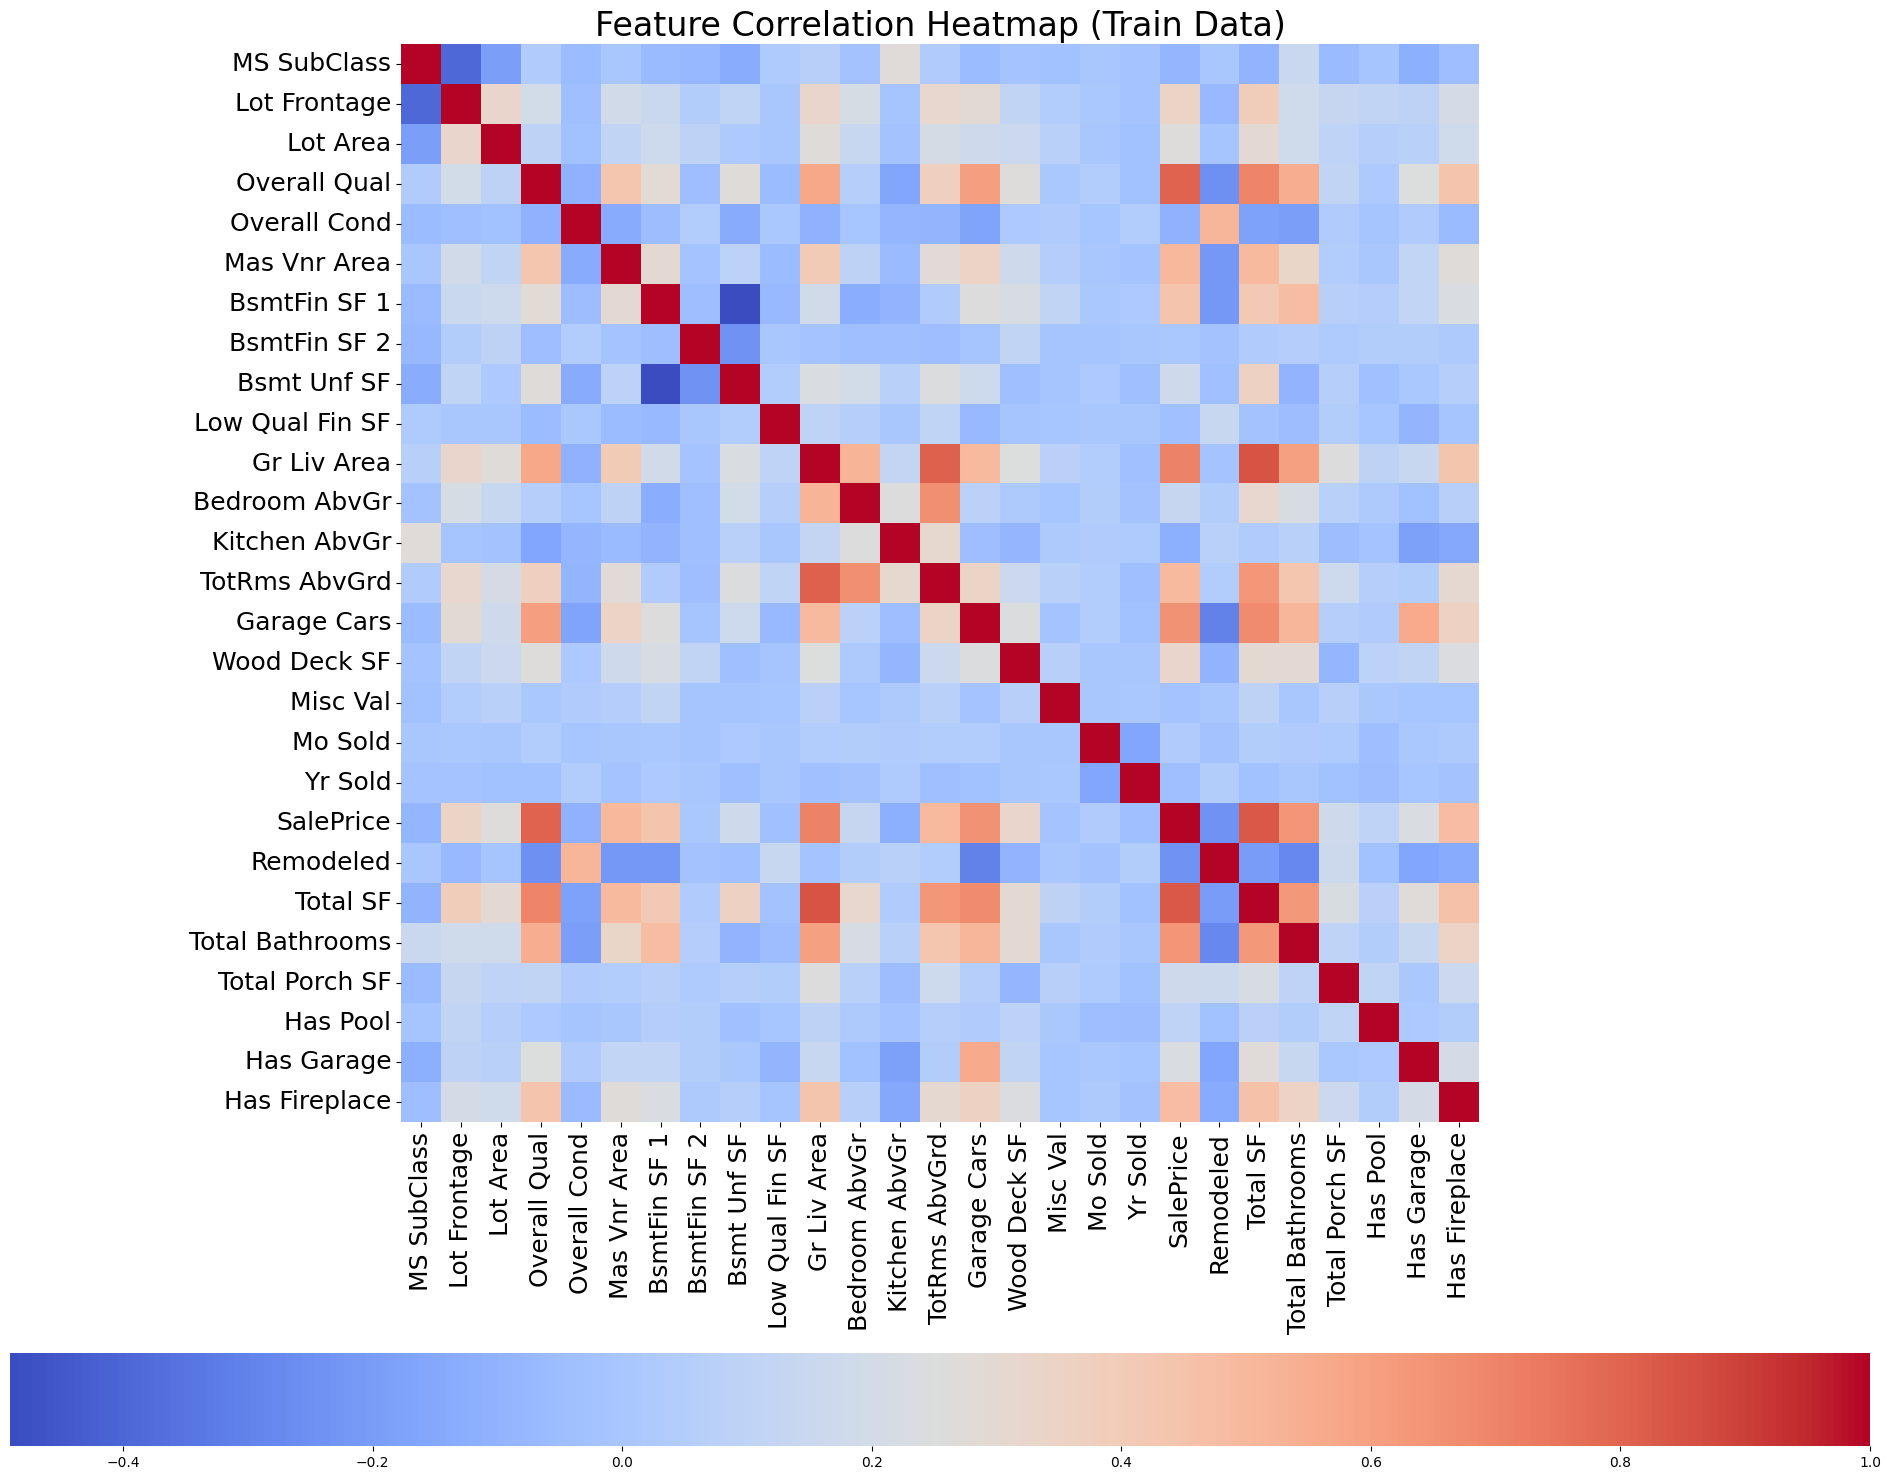

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = dfTrain.select_dtypes(include='number')
corr_matrix = numeric_df.corr()

plt.figure(figsize=(24, 20))
ax = sns.heatmap(
    corr_matrix,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"orientation": "horizontal"}
)
plt.title("Feature Correlation Heatmap (Train Data)", fontsize=24)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18, rotation=0)
plt.show()


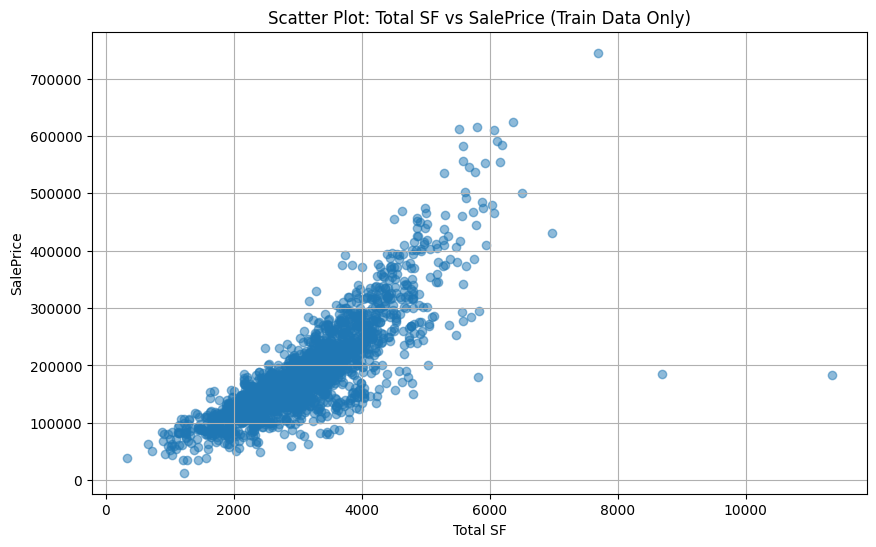

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(dfTrain['Total SF'], dfTrain['SalePrice'], alpha=0.5)
plt.xlabel('Total SF')
plt.ylabel('SalePrice')
plt.title('Scatter Plot: Total SF vs SalePrice (Train Data Only)')
plt.grid(True)
plt.show()


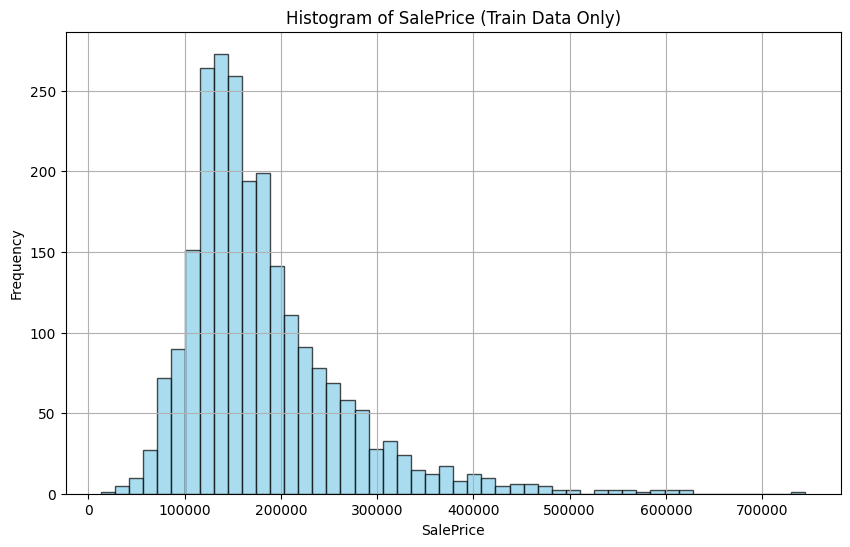

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dfTrain['SalePrice'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Histogram of SalePrice (Train Data Only)')
plt.grid(True)
plt.show()
